
Here I see that hidden sparse subnetworks also show implicit rank minimization property even though the weights of the sparse subnetworks were frozen from the beginning and thus never trained using SGD. Indicates that there are some other factors at play that causes generalization.

In [ ]:
%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

Parameter Settings
-------------------


In [ ]:
latent_dims = 128
num_epochs = 50
batch_size = 128
capacity = 24
learning_rate = 1e-3
use_gpu = True

Results on MNIST
-------------------

In the paper, they have used a latent dimension of 128 and number of linear layers at the end of encoder as 8

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw


Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw




Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw


Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Autoencoder Definition
-----------------------
For $\mathcal{l}$=8, there are 8 linear layers that the output of the encoder is passed through to get the latent code



In [ ]:
from __future__ import print_function
import argparse
import os
import math
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
from torch.nn.utils import prune
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.autograd as autograd

Refer to Ramanujan et. al What'ss 

In [ ]:
class GetSubnet(autograd.Function):
    @staticmethod
    def forward(ctx, scores, k):
        # Get the supermask by sorting the scores and using the top k%
        out = scores.clone()
        _, idx = scores.flatten().sort()
        j = int((1 - k) * scores.numel())
 
        # flat_out and out access the same memory.
        flat_out = out.flatten()
        flat_out[idx[:j]] = 0
        flat_out[idx[j:]] = 1
 
        return out
 
    @staticmethod
    def backward(ctx, g):
        # send the gradient g straight-through on the backward pass.
        return g, None

In [ ]:
## define sparsity
k = 0.5

In [ ]:
class SupermaskLinear(nn.Linear):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
 
        # initialize the scores
        self.scores = nn.Parameter(torch.Tensor(self.weight.size()))
        nn.init.kaiming_uniform_(self.scores, a=math.sqrt(5))
 
        # NOTE: initialize the weights like this.
        nn.init.kaiming_normal_(self.weight, mode="fan_in", nonlinearity="relu")
 
        # NOTE: turn the gradient on the weights off
        self.weight.requires_grad = False
 
    def forward(self, x):
        subnet = GetSubnet.apply(self.scores.abs(), k)
        w = self.weight * subnet
        return F.linear(x, w, self.bias)
        return x

In [ ]:
class SupermaskConvTranspose(nn.ConvTranspose2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # initialize the scores
        self.scores = nn.Parameter(torch.Tensor(self.weight.size()))
        nn.init.kaiming_uniform_(self.scores, a=math.sqrt(5))

        # NOTE: initialize the weights like this.
        nn.init.kaiming_normal_(self.weight, mode="fan_in", nonlinearity="relu")

        # NOTE: turn the gradient on the weights off
        self.weight.requires_grad = False
        
    def forward(self, x):
        subnet = GetSubnet.apply(self.scores.abs(), k)
        w = self.weight * subnet
        x = F.conv_transpose2d(
            x, w, self.bias, self.stride, self.padding, self.output_padding, self.groups, self.dilation 
        )
        return x

In [ ]:
class SupermaskConv(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # initialize the scores
        self.scores = nn.Parameter(torch.Tensor(self.weight.size()))
        nn.init.kaiming_uniform_(self.scores, a=math.sqrt(5))

        # NOTE: initialize the weights like this.
        nn.init.kaiming_normal_(self.weight, mode="fan_in", nonlinearity="relu")

        # NOTE: turn the gradient on the weights off
        self.weight.requires_grad = False

    def forward(self, x):
        subnet = GetSubnet.apply(self.scores.abs(), k)
        w = self.weight * subnet
        x = F.conv2d(
            x, w, self.bias, self.stride, self.padding, self.dilation, self.groups
        )
        return x

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = SupermaskConv(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = SupermaskConv(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.conv3 = SupermaskConv(in_channels=c*2, out_channels=c, kernel_size=1) # out: c x 7 x 7
        self.fc = SupermaskLinear(in_features=c*7*7, out_features=latent_dims)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x = self.fc(x)
        
        return x
        

In [ ]:
class LNN(nn.Module):
    def __init__(self, num_of_linear_layers, type):
        self.num_of_linear_layers = num_of_linear_layers
        super(LNN, self).__init__()

        self.linear_layer = nn.ModuleList([SupermaskLinear(in_features=latent_dims, out_features=latent_dims) for _ in range(num_of_linear_layers)])
        self.forward = self.forward_linear
        
    def forward_linear(self, x):
        for layer in self.linear_layer:
            x = layer(x)
        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = SupermaskLinear(in_features=latent_dims, out_features=c*7*7)
        self.conv3 = SupermaskConvTranspose(in_channels=c, out_channels=c*2, kernel_size=1)
        self.conv2 = SupermaskConvTranspose(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = SupermaskConvTranspose(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
        
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv2(x))
        x = torch.tanh(self.conv1(x)) # last layer before output is tanh, since the images are normalized and 0-centered
        return x
        # x = self.decoder(x)
        # x = x.view(x.size(0), 1, 28, 28)
        # return x

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.lnn = LNN(*args, **kwargs)
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        min_rank_latent = self.lnn(latent)
        x_recon = self.decoder(min_rank_latent)
        # x_recon = self.decoder(latent)
        return x_recon

In [ ]:
autoencoder = Autoencoder(8,'linear')

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
autoencoder = autoencoder.to(device)

num_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 474561


In [ ]:
autoencoder(torch.rand(128,1,28,28).cuda()).shape

torch.Size([128, 1, 28, 28])

Train Autoencoder
--------

In [ ]:
def train(layers=0, type="linear", model=None, lr=1e-3, num_epochs=50):
    print(lr)
    if model == None:
        autoencoder = Autoencoder(layers, type)
    else:
        autoencoder = model
    
    device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
    autoencoder = autoencoder.to(device)
    num_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
    print('Number of parameters: %d' % num_params)
    optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate)#, momentum=0.5)

    # set to training mode
    autoencoder.train()

    train_loss_avg = []

    print('Training ...')
    for epoch in range(num_epochs):
        train_loss_avg.append(0)
        num_batches = 0
        
        for image_batch, _ in train_dataloader:
            # print(image_batch.shape)
            image_batch = image_batch.to(device)
            
            # autoencoder reconstruction
            image_batch_recon = autoencoder(image_batch)
            
            # reconstruction error
            loss = F.mse_loss(image_batch_recon, image_batch)
            
            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            
            # one step of the optmizer (using the gradients from backpropagation)
            optimizer.step()
            
            train_loss_avg[-1] += loss.item()
            num_batches += 1
            
        train_loss_avg[-1] /= num_batches
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))
    return autoencoder, train_loss_avg

In [ ]:
capacity = 24

In [129]:
standard_ae, standard_ae_train_loss_avg = train(0, 'linear', num_epochs=20)

0.001
Number of parameters: 342465
Training ...
Epoch [1 / 20] average reconstruction error: 0.108380
Epoch [2 / 20] average reconstruction error: 0.042558
Epoch [3 / 20] average reconstruction error: 0.037294
Epoch [4 / 20] average reconstruction error: 0.035595
Epoch [5 / 20] average reconstruction error: 0.034318
Epoch [6 / 20] average reconstruction error: 0.033756
Epoch [7 / 20] average reconstruction error: 0.032691
Epoch [8 / 20] average reconstruction error: 0.031772
Epoch [9 / 20] average reconstruction error: 0.031426
Epoch [10 / 20] average reconstruction error: 0.030841
Epoch [11 / 20] average reconstruction error: 0.030420
Epoch [12 / 20] average reconstruction error: 0.029789
Epoch [13 / 20] average reconstruction error: 0.029646
Epoch [14 / 20] average reconstruction error: 0.029647
Epoch [15 / 20] average reconstruction error: 0.029077
Epoch [16 / 20] average reconstruction error: 0.029077
Epoch [17 / 20] average reconstruction error: 0.028596
Epoch [18 / 20] average re

In [102]:
linear_irmae = Autoencoder(8,'linear')

In [ ]:
from copy import deepcopy

Creating copy of the initial parameters to verify that the weights have not changed and remained the same

In [106]:
a = deepcopy(linear_irmae.encoder.fc.weight.data.cpu().numpy())
b = deepcopy(linear_irmae.lnn.linear_layer[0].weight.data.cpu().numpy())
c = deepcopy(linear_irmae.decoder.fc.scores.data.cpu().numpy())

In [116]:
print(np.all(linear_irmae.encoder.fc.weight.data.cpu().numpy() == a))
print(np.all(b == linear_irmae.lnn.linear_layer[0].weight.data.cpu().numpy()))
print(np.all(c == linear_irmae.decoder.fc.scores.data.cpu().numpy()))

## They are equal initially

True
True
True


In [117]:
linear_irmae, linear_train_loss_avg = train(model=linear_irmae, lr=1e-1, num_epochs=20)

0.1
Number of parameters: 474561
Training ...
Epoch [1 / 20] average reconstruction error: 0.141108
Epoch [2 / 20] average reconstruction error: 0.073877
Epoch [3 / 20] average reconstruction error: 0.067616
Epoch [4 / 20] average reconstruction error: 0.065348
Epoch [5 / 20] average reconstruction error: 0.064411
Epoch [6 / 20] average reconstruction error: 0.062969
Epoch [7 / 20] average reconstruction error: 0.061190
Epoch [8 / 20] average reconstruction error: 0.060086
Epoch [9 / 20] average reconstruction error: 0.059994
Epoch [10 / 20] average reconstruction error: 0.059425
Epoch [11 / 20] average reconstruction error: 0.058197
Epoch [12 / 20] average reconstruction error: 0.057615
Epoch [13 / 20] average reconstruction error: 0.056382
Epoch [14 / 20] average reconstruction error: 0.055846
Epoch [15 / 20] average reconstruction error: 0.055192
Epoch [16 / 20] average reconstruction error: 0.055151
Epoch [17 / 20] average reconstruction error: 0.054802
Epoch [18 / 20] average reco

In [145]:
## Check again to see if the weights are still equal or not

print(np.all(a == linear_irmae.encoder.fc.weight.data.cpu().numpy()))
print(np.all(b == linear_irmae.lnn.linear_layer[0].weight.data.cpu().numpy()))
print(np.all(c == linear_irmae.decoder.fc.scores.data.cpu().numpy()))


True
True
False


Note that only the scores have changed but that does not make any difference to us because top-k% scores will determine the mask of the weights to be used. Only the weights with top-k% scores are used to find the output and since the weights haven't changed SGD should not show any effect regarding the generalization or rank minimization of the network.

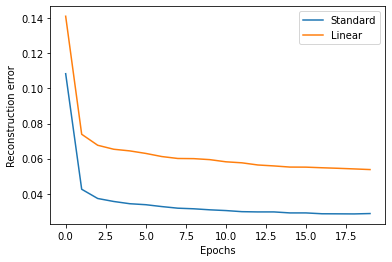

In [130]:
fig = plt.figure()
plt.plot(standard_ae_train_loss_avg, label="Standard")
plt.plot(linear_train_loss_avg, label="Linear")
plt.legend(loc="upper right")
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()
# plt.savefig("train_plot_1.png")

Evaluate on the Test Set
-------------------------

In [121]:
def get_singular_values(trained_irmae):
    cov_latent = torch.zeros((latent_dims,latent_dims)).to(device)
    trained_irmae.eval()
    test_loss_avg, num_batches = 0, 0
    for image_batch, _ in test_dataloader:
        
        with torch.no_grad():

            image_batch = image_batch.to(device)

            # autoencoder reconstruction
            latent = trained_irmae.encoder(image_batch)
            min_rank_latent = trained_irmae.lnn(latent)
            cov_latent += min_rank_latent.T @ min_rank_latent
            image_batch_recon = trained_irmae(image_batch)

            # reconstruction error
            loss = F.mse_loss(image_batch_recon, image_batch)

            test_loss_avg += loss.item()
            num_batches += 1
        
    test_loss_avg /= num_batches
    print('average reconstruction error: %f' % (test_loss_avg))
    _,d,_ = torch.svd(cov_latent)
    return cov_latent, (d/d.max()).cpu()

In [143]:
standard_cov, standard_ae_singular_values = get_singular_values(standard_ae)
linear_cov, linear_singular_values = get_singular_values(linear_irmae)

average reconstruction error: 0.025495
average reconstruction error: 0.053427


In [144]:
print(torch.matrix_rank(standard_cov))
print(torch.matrix_rank(linear_cov))

tensor(128, device='cuda:0')
tensor(27, device='cuda:0')


Surprisingly, the rank of the latent space covariance matrix for the network with linear layers inserted is much less than of the standard variant without any linear layer inserted. This is contradictory to the results presented by many papers that show that SGD causes the implicit rank minimization effect. Yet, here we see that network with weights which are completely frozen from the beginning and never updated using SGD still show rank minimization property.

(0.0, 0.2)

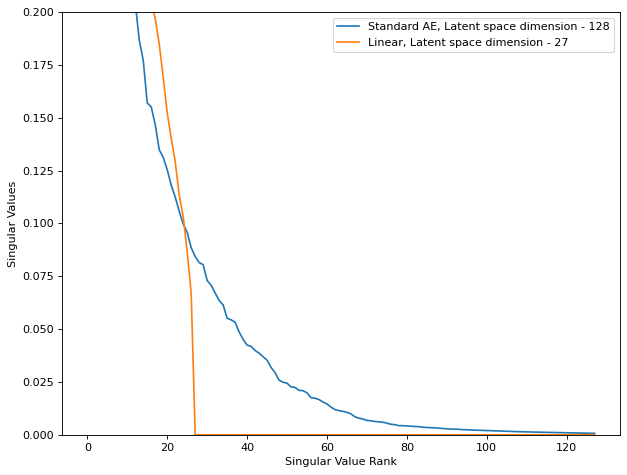

In [133]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(9, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(standard_ae_singular_values, label=f'Standard AE, Latent space dimension - {torch.matrix_rank(standard_cov)}')
plt.plot(linear_singular_values, label=f'Linear, Latent space dimension - {torch.matrix_rank(linear_cov)}')
plt.ylabel('Singular Values')
plt.xlabel('Singular Value Rank')
plt.legend(loc="upper right")
plt.ylim(0,0.2)

Visualize Reconstructions
--------------------------

In [140]:
# autoencoder = standard_ae
autoencoder = linear_irmae

Original images


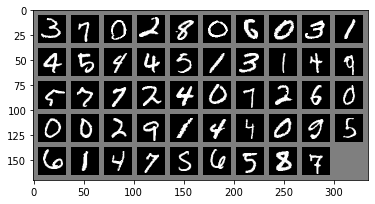

Autoencoder reconstruction:


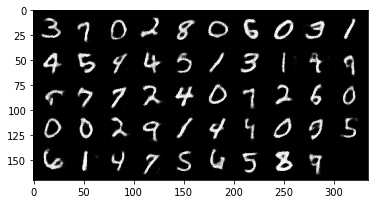

In [141]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

autoencoder.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():

        images = images.to(device)
        images = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = iter(test_dataloader).next()

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the autoencoder
print('Autoencoder reconstruction:')
visualise_output(images, autoencoder)

Interpolate in Latent Space
----------------------------

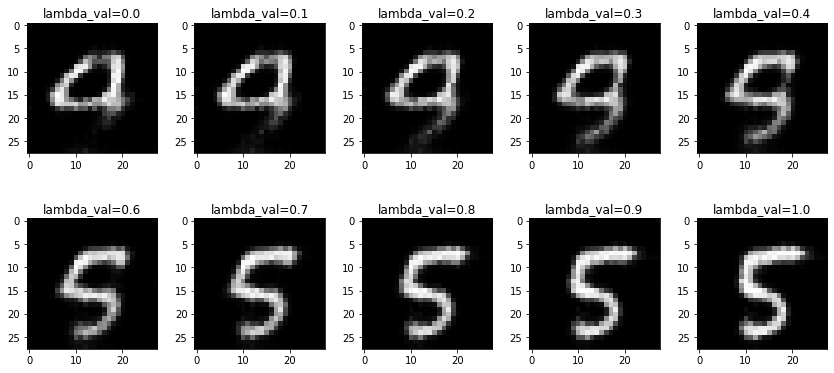

In [142]:
autoencoder.eval()

def interpolation(lambda1, model, img1, img2):
    
    with torch.no_grad():

        # latent vector of first image
        img1 = img1.to(device)
        latent_1 = model.encoder(img1)
        latent_1 = model.lnn(latent_1)
        

        # latent vector of second image
        img2 = img2.to(device)
        latent_2 = model.encoder(img2)
        latent_2 = model.lnn(latent_2)

        # interpolation of the two latent vectors
        inter_latent = lambda1 * latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()
    
    return inter_image
    
# sort part of test set by digit
digits = [[] for _ in range(10)]
for img_batch, label_batch in test_dataloader:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in digits) >= 1000:
        break;

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()


for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), autoencoder, digits[5][0], digits[4][45])
  
    inter_image = to_img(inter_image)
    
    image = inter_image.numpy()
  
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))

plt.show() 